import images

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

def main():
    global train_loader, valid_loader, test_loader, device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define root folder & classes
    file_folder = r"C:\Users\majas\A COVID PROJEKT\COVID-19_Radiography_Dataset"
    classes = ["COVID", "Normal", 'Lung_Opacity', 'Viral Pneumonia']

    # Collect images & masks
    class ImageDataProcessor:
        def __init__(self, file_folder, classes):
            self.file_folder = file_folder
            self.classes = classes
            self.data = self.collect_image_and_mask_path()

        def collect_image_and_mask_path(self):
            data = {}
            for cls in self.classes:
                cls_dir = os.path.join(self.file_folder, cls)
                images, masks = [], []

                if not os.path.exists(cls_dir):
                    print(f"Folder does not exist: {cls_dir}")
                    data[cls] = {"images": [], "masks": []}
                    continue

                for root, _, files in os.walk(cls_dir):
                    for file in files:
                        if file.lower().endswith((".png", ".jpg", ".jpeg")):
                            path = os.path.join(root, file)
                            if "mask" in root.lower():
                                masks.append(path)
                            else:
                                images.append(path)

                data[cls] = {"images": images, "masks": masks}
            return data

    # Collect data
    pic_data = ImageDataProcessor(file_folder, classes)
    all_images = []
    all_masks = []

    for cls, paths in pic_data.data.items():
        all_images.extend(paths["images"])
        all_masks.extend(paths["masks"])

    print(f"Total number of images: {len(all_images)}")
    print(f"Total number of masks: {len(all_masks)}")

    if len(all_images) == 0 or len(all_masks) == 0:
        raise ValueError("ERROR: No images or masks found! Check the file path.")

    assert len(all_images) == len(all_masks), f"Error: {len(all_images)} images, but {len(all_masks)} masks!"

    # Set dataset split sizes
    train_size = int(0.7 * len(all_images))
    valid_size = int(0.2 * len(all_images))
    test_size = len(all_images) - train_size - valid_size

    print(f"Train Size: {train_size}, Valid Size: {valid_size}, Test Size: {test_size}")

    train_image_paths, train_mask_paths = all_images[:train_size], all_masks[:train_size]
    valid_image_paths, valid_mask_paths = all_images[train_size:train_size + valid_size], all_masks[train_size:train_size + valid_size]
    test_image_paths, test_mask_paths = all_images[train_size + valid_size:], all_masks[train_size + valid_size:]

    assert len(train_image_paths) > 0, "Error: Train dataset is empty!"
    assert len(valid_image_paths) > 0, "Error: Validation dataset is empty!"
    assert len(test_image_paths) > 0, "Error: Test dataset is empty!"

    # Dataset class
    class CustomLungSegmentationDataset(Dataset):
        def __init__(self, image_paths, mask_paths, transform_img=None, transform_mask=None):
            self.image_paths = image_paths
            self.mask_paths = mask_paths
            self.transform_img = transform_img
            self.transform_mask = transform_mask

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]

            if not os.path.exists(image_path):
                print(f"Missing image: {image_path}")
            if not os.path.exists(mask_path):
                print(f"Missing mask: {mask_path}")

            image = Image.open(image_path).convert("L")
            mask = Image.open(mask_path).convert("L")

            if self.transform_img:
                image = self.transform_img(image)
            if self.transform_mask:
                mask = self.transform_mask(mask)

            mask = (mask > 0).float()
            return image, mask

    # Define transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    # Create datasets
    train_dataset = CustomLungSegmentationDataset(train_image_paths, train_mask_paths, image_transform, mask_transform)
    valid_dataset = CustomLungSegmentationDataset(valid_image_paths, valid_mask_paths, image_transform, mask_transform)
    test_dataset  = CustomLungSegmentationDataset(test_image_paths,  test_mask_paths,  image_transform, mask_transform)

    # Create dataloaders
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

    # Check dataloaders
    for name, loader in zip(["Train", "Valid", "Test"], [train_loader, valid_loader, test_loader]):
        print(f"{name} DataLoader: {len(loader)} batches loaded.")

    print("Loading training dataset...")
    for batch_idx, (train_images, train_masks) in enumerate(tqdm(train_loader, desc="Training Data", unit="batch")):
        train_images, train_masks = train_images.to(device), train_masks.to(device)

    print("Loading validation dataset...")
    for batch_idx, (valid_images, valid_masks) in enumerate(tqdm(valid_loader, desc="Validation Data", unit="batch")):
        valid_images, valid_masks = valid_images.to(device), valid_masks.to(device)

    print("Loading test dataset...")
    for batch_idx, (test_images, test_masks) in enumerate(tqdm(test_loader, desc="Test Data", unit="batch")):
        test_images, test_masks = test_images.to(device), test_masks.to(device)

    print("All datasets successfully loaded into DataLoaders.")

    # Inspect one batch
    train_images, train_masks = next(iter(train_loader))
    train_images, train_masks = train_images.to(device), train_masks.to(device)
    print(f"Train batch shape: {train_images.shape}, {train_masks.shape}")

    print(f"Train image min: {train_images.min().item()}, max: {train_images.max().item()}")
    print(f"Train mask min: {train_masks.min().item()}, max: {train_masks.max().item()}")

main()


Gerät verwendet: cuda
Gesamtzahl der Bilder: 21165
Gesamtzahl der Masken: 21165
Train Size: 14815, Valid Size: 4233, Test Size: 2117
 Train DataLoader: 1852 Batches geladen.
 Valid DataLoader: 530 Batches geladen.
 Test DataLoader: 265 Batches geladen.
Laden des Training-Datasets...


Training Data: 100%|██████████| 1852/1852 [01:18<00:00, 23.60batch/s]


Laden des Validierungs-Datasets...


Validation Data: 100%|██████████| 530/530 [00:19<00:00, 26.79batch/s]


Laden des Test-Datasets...


Test Data: 100%|██████████| 265/265 [00:10<00:00, 26.04batch/s]


Alle Daten wurden erfolgreich in den DataLoader geladen.
Train Batch Shape: torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256])
Train Bild Min: -1.0, Max: 1.0
Train Maske Min: 0.0, Max: 1.0


debuggingpart

 Anzahl der Batches in den DataLoadern:
   Train DataLoader: 1852 Batches
    Valid DataLoader: 530 Batches
   Test DataLoader:  265 Batches

 bildgrößen im Batch (Trainingsdaten)
    Image Shape: torch.Size([8, 1, 256, 256])
    Mask Shape:  torch.Size([8, 1, 256, 256])

 **Normalisierung Check (Train Batch)**
    Image Min: -1.0, Max: 1.0
    Mask Min:  0.0, Max: 1.0



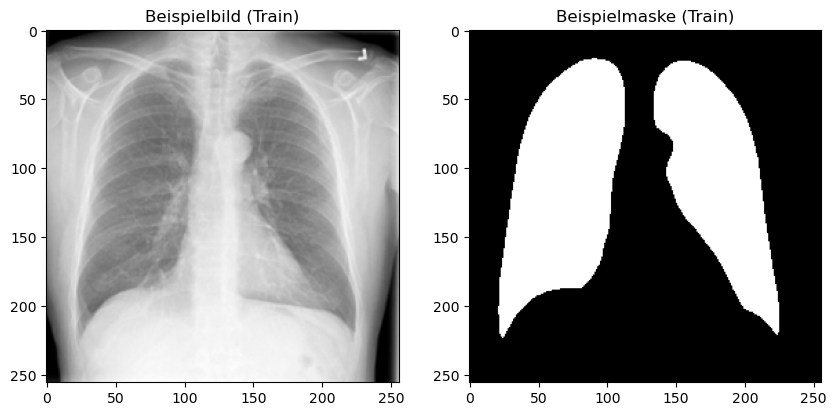

 Manuell gezählte Bilder:
    Train DataLoader: 14815 Bilder
    Valid DataLoader: 4233 Bilder
    Test DataLoader:  2117 Bilder



In [ ]:

print(f" Number of batches in the DataLoaders:")
print(f"   Train DataLoader: {len(train_loader)} batches")
print(f"   Valid DataLoader: {len(valid_loader)} batches")
print(f"   Test DataLoader:  {len(test_loader)} batches\n")


train_images, train_masks = next(iter(train_loader))
train_images, train_masks = train_images.to(device), train_masks.to(device)  # Transfer to GPU


print(" Image sizes in batch (Training data)")
print(f"    Image Shape: {train_images.shape}")  # (Batch, Channels, Height, Width)
print(f"    Mask Shape:  {train_masks.shape}\n")


print(" **Normalization Check (Train Batch)**")
print(f"    Image Min: {train_images.min().item()}, Max: {train_images.max().item()}")
print(f"    Mask Min:  {train_masks.min().item()}, Max: {train_masks.max().item()}\n")


sample_image = train_images[0].cpu().squeeze().numpy()
sample_mask = train_masks[0].cpu().squeeze().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image, cmap="gray")
ax[0].set_title("Sample Image (Train)")

ax[1].imshow(sample_mask, cmap="gray")
ax[1].set_title("Sample Mask (Train)")

plt.show()


train_total = 0
for batch_images, _ in train_loader:
    train_total += batch_images.size(0)

valid_total = 0
for batch_images, _ in valid_loader:
    valid_total += batch_images.size(0)

test_total = 0
for batch_images, _ in test_loader:
    test_total += batch_images.size(0)

# Print the result
print(f" Manually counted images:")
print(f"    Train DataLoader: {train_total} images")
print(f"    Valid DataLoader: {valid_total} images")
print(f"    Test DataLoader:  {test_total} images\n")


first model

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics

# === Initialize the model with EfficientNet-b5 encoder ===
model = smp.Unet(
    encoder_name="efficientnet-b5",       
    encoder_weights=None,                 
    in_channels=1,                        
    classes=1                             
).to(device)

# Check device (CPU/GPU) 
print(f"Model is located on: {next(model.parameters()).device}")

# Loss function & optimizer 
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Learning rate scheduler ===
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# Additional metrics 
dice_metric = torchmetrics.Dice(threshold=0.5).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# === Training settings ===
num_epochs = 35
best_loss = float("inf")
epochs_no_improve = 0
patience = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    print(f"\n Epoch {epoch+1}/{num_epochs}")

    for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Update metrics
        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Compute averages
    train_loss = epoch_loss / len(train_loader)
    train_dice = dice_metric.compute().item()
    train_iou = iou_metric.compute().item()

    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validating", dynamic_ncols=True):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            dice_metric.update(torch.sigmoid(outputs), masks.long())
            iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Compute validation averages
    val_loss = val_loss / len(valid_loader)
    val_dice = dice_metric.compute().item()
    val_iou = iou_metric.compute().item()

    print(f"Validation Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model 
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "model_24_2_.pth")
        print("  New best model saved!")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve}/{patience} epochs.")

    # Adjust learning rate 
    scheduler.step(val_loss)

    # Early stopping 
    if epochs_no_improve >= patience:
        print("  Early stopping triggered! No further improvement.")
        break

# Load best model after training 
print("Loading best model for final evaluation...")
model.load_state_dict(torch.load("model_24_2_.pth"))

# Save the final model 
final_model_path = "model_24_2_.pth"
torch.save(model.state_dict(), final_model_path)
print(f" Model saved as {final_model_path} & training completed!")


c:\Users\majas\anaconda3\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Modell befindet sich auf: cuda:0

 Epoch 1/35


Train Epoch 1/35: 100%|██████████| 1852/1852 [1:18:38<00:00,  2.55s/it]


Train Loss: 0.0361 | Train Dice: 0.9676 | Train IoU: 0.9371


Validating: 100%|██████████| 530/530 [06:06<00:00,  1.45it/s]


Validation Loss: 0.0392 | Val Dice: 0.9614 | Val IoU: 0.9256
 Neues bestes Modell gespeichert!

 Epoch 2/35


Train Epoch 2/35: 100%|██████████| 1852/1852 [1:10:52<00:00,  2.30s/it]


Train Loss: 0.0156 | Train Dice: 0.9846 | Train IoU: 0.9697


Validating: 100%|██████████| 530/530 [03:54<00:00,  2.26it/s]


Validation Loss: 0.0294 | Val Dice: 0.9709 | Val IoU: 0.9435
 Neues bestes Modell gespeichert!

 Epoch 3/35


Train Epoch 3/35: 100%|██████████| 1852/1852 [1:07:57<00:00,  2.20s/it]


Train Loss: 0.0140 | Train Dice: 0.9862 | Train IoU: 0.9727


Validating: 100%|██████████| 530/530 [05:10<00:00,  1.71it/s]


Validation Loss: 0.0304 | Val Dice: 0.9699 | Val IoU: 0.9416
 Keine Verbesserung für 1/5 Epochen.

 Epoch 4/35


Train Epoch 4/35: 100%|██████████| 1852/1852 [25:01<00:00,  1.23it/s]


Train Loss: 0.0125 | Train Dice: 0.9876 | Train IoU: 0.9755


Validating: 100%|██████████| 530/530 [04:08<00:00,  2.13it/s]


Validation Loss: 0.0300 | Val Dice: 0.9703 | Val IoU: 0.9423
 Keine Verbesserung für 2/5 Epochen.

 Epoch 5/35


Train Epoch 5/35: 100%|██████████| 1852/1852 [50:43<00:00,  1.64s/it] 


Train Loss: 0.0122 | Train Dice: 0.9879 | Train IoU: 0.9761


Validating: 100%|██████████| 530/530 [05:25<00:00,  1.63it/s]


Validation Loss: 0.0240 | Val Dice: 0.9762 | Val IoU: 0.9535
 Neues bestes Modell gespeichert!

 Epoch 6/35


Train Epoch 6/35: 100%|██████████| 1852/1852 [1:09:52<00:00,  2.26s/it]


Train Loss: 0.0112 | Train Dice: 0.9889 | Train IoU: 0.9780


Validating: 100%|██████████| 530/530 [05:24<00:00,  1.63it/s]


Validation Loss: 0.0249 | Val Dice: 0.9753 | Val IoU: 0.9518
 Keine Verbesserung für 1/5 Epochen.

 Epoch 7/35


Train Epoch 7/35: 100%|██████████| 1852/1852 [1:08:23<00:00,  2.22s/it]


Train Loss: 0.0109 | Train Dice: 0.9892 | Train IoU: 0.9786


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0216 | Val Dice: 0.9786 | Val IoU: 0.9581
 Neues bestes Modell gespeichert!

 Epoch 8/35


Train Epoch 8/35: 100%|██████████| 1852/1852 [1:08:16<00:00,  2.21s/it]


Train Loss: 0.0102 | Train Dice: 0.9898 | Train IoU: 0.9799


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0222 | Val Dice: 0.9780 | Val IoU: 0.9569
 Keine Verbesserung für 1/5 Epochen.

 Epoch 9/35


Train Epoch 9/35: 100%|██████████| 1852/1852 [1:08:29<00:00,  2.22s/it]


Train Loss: 0.0095 | Train Dice: 0.9905 | Train IoU: 0.9812


Validating: 100%|██████████| 530/530 [05:20<00:00,  1.65it/s]


Validation Loss: 0.0231 | Val Dice: 0.9771 | Val IoU: 0.9552
 Keine Verbesserung für 2/5 Epochen.

 Epoch 10/35


Train Epoch 10/35: 100%|██████████| 1852/1852 [1:08:17<00:00,  2.21s/it]


Train Loss: 0.0099 | Train Dice: 0.9902 | Train IoU: 0.9806


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0209 | Val Dice: 0.9793 | Val IoU: 0.9593
 Neues bestes Modell gespeichert!

 Epoch 11/35


Train Epoch 11/35: 100%|██████████| 1852/1852 [1:08:19<00:00,  2.21s/it]


Train Loss: 0.0092 | Train Dice: 0.9909 | Train IoU: 0.9819


Validating: 100%|██████████| 530/530 [05:19<00:00,  1.66it/s]


Validation Loss: 0.0212 | Val Dice: 0.9790 | Val IoU: 0.9588
 Keine Verbesserung für 1/5 Epochen.

 Epoch 12/35


Train Epoch 12/35: 100%|██████████| 1852/1852 [1:08:33<00:00,  2.22s/it]


Train Loss: 0.0089 | Train Dice: 0.9912 | Train IoU: 0.9825


Validating: 100%|██████████| 530/530 [05:20<00:00,  1.65it/s]


Validation Loss: 0.0247 | Val Dice: 0.9755 | Val IoU: 0.9522
 Keine Verbesserung für 2/5 Epochen.

 Epoch 13/35


Train Epoch 13/35: 100%|██████████| 1852/1852 [1:08:19<00:00,  2.21s/it]


Train Loss: 0.0087 | Train Dice: 0.9913 | Train IoU: 0.9828


Validating: 100%|██████████| 530/530 [05:20<00:00,  1.66it/s]


Validation Loss: 0.0190 | Val Dice: 0.9811 | Val IoU: 0.9629
 Neues bestes Modell gespeichert!

 Epoch 14/35


Train Epoch 14/35: 100%|██████████| 1852/1852 [1:02:31<00:00,  2.03s/it]


Train Loss: 0.0086 | Train Dice: 0.9915 | Train IoU: 0.9831


Validating: 100%|██████████| 530/530 [04:49<00:00,  1.83it/s]


Validation Loss: 0.0200 | Val Dice: 0.9802 | Val IoU: 0.9612
 Keine Verbesserung für 1/5 Epochen.

 Epoch 15/35


Train Epoch 15/35: 100%|██████████| 1852/1852 [1:03:38<00:00,  2.06s/it]


Train Loss: 0.0083 | Train Dice: 0.9918 | Train IoU: 0.9837


Validating: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0180 | Val Dice: 0.9821 | Val IoU: 0.9649
 Neues bestes Modell gespeichert!

 Epoch 16/35


Train Epoch 16/35: 100%|██████████| 1852/1852 [1:10:25<00:00,  2.28s/it]


Train Loss: 0.0081 | Train Dice: 0.9920 | Train IoU: 0.9841


Validating: 100%|██████████| 530/530 [05:26<00:00,  1.62it/s]


Validation Loss: 0.0196 | Val Dice: 0.9805 | Val IoU: 0.9618
 Keine Verbesserung für 1/5 Epochen.

 Epoch 17/35


Train Epoch 17/35: 100%|██████████| 1852/1852 [45:31<00:00,  1.48s/it] 


Train Loss: 0.0079 | Train Dice: 0.9922 | Train IoU: 0.9845


Validating: 100%|██████████| 530/530 [05:51<00:00,  1.51it/s]


Validation Loss: 0.0181 | Val Dice: 0.9820 | Val IoU: 0.9646
 Keine Verbesserung für 2/5 Epochen.

 Epoch 18/35


Train Epoch 18/35: 100%|██████████| 1852/1852 [1:02:57<00:00,  2.04s/it]


Train Loss: 0.0079 | Train Dice: 0.9922 | Train IoU: 0.9845


Validating: 100%|██████████| 530/530 [04:49<00:00,  1.83it/s]


Validation Loss: 0.0180 | Val Dice: 0.9822 | Val IoU: 0.9650
 Neues bestes Modell gespeichert!

 Epoch 19/35


Train Epoch 19/35: 100%|██████████| 1852/1852 [1:01:46<00:00,  2.00s/it]


Train Loss: 0.0077 | Train Dice: 0.9923 | Train IoU: 0.9848


Validating: 100%|██████████| 530/530 [04:49<00:00,  1.83it/s]


Validation Loss: 0.0181 | Val Dice: 0.9821 | Val IoU: 0.9648
 Keine Verbesserung für 1/5 Epochen.

 Epoch 20/35


Train Epoch 20/35: 100%|██████████| 1852/1852 [1:01:53<00:00,  2.00s/it]


Train Loss: 0.0074 | Train Dice: 0.9927 | Train IoU: 0.9855


Validating: 100%|██████████| 530/530 [05:19<00:00,  1.66it/s]


Validation Loss: 0.0192 | Val Dice: 0.9810 | Val IoU: 0.9626
 Keine Verbesserung für 2/5 Epochen.

 Epoch 21/35


Train Epoch 21/35: 100%|██████████| 1852/1852 [1:08:20<00:00,  2.21s/it]


Train Loss: 0.0073 | Train Dice: 0.9927 | Train IoU: 0.9856


Validating: 100%|██████████| 530/530 [05:18<00:00,  1.66it/s]


Validation Loss: 0.0184 | Val Dice: 0.9817 | Val IoU: 0.9641
 Keine Verbesserung für 3/5 Epochen.

 Epoch 22/35


Train Epoch 22/35: 100%|██████████| 1852/1852 [1:08:04<00:00,  2.21s/it]


Train Loss: 0.0072 | Train Dice: 0.9928 | Train IoU: 0.9858


Validating: 100%|██████████| 530/530 [05:18<00:00,  1.66it/s]


Validation Loss: 0.0175 | Val Dice: 0.9827 | Val IoU: 0.9660
 Neues bestes Modell gespeichert!

 Epoch 23/35


Train Epoch 23/35: 100%|██████████| 1852/1852 [1:07:39<00:00,  2.19s/it]


Train Loss: 0.0071 | Train Dice: 0.9930 | Train IoU: 0.9860


Validating: 100%|██████████| 530/530 [04:48<00:00,  1.83it/s]


Validation Loss: 0.0172 | Val Dice: 0.9829 | Val IoU: 0.9664
 Neues bestes Modell gespeichert!

 Epoch 24/35


Train Epoch 24/35: 100%|██████████| 1852/1852 [23:55<00:00,  1.29it/s] 


Train Loss: 0.0069 | Train Dice: 0.9932 | Train IoU: 0.9864


Validating: 100%|██████████| 530/530 [01:35<00:00,  5.57it/s]


Validation Loss: 0.0171 | Val Dice: 0.9830 | Val IoU: 0.9666
 Neues bestes Modell gespeichert!

 Epoch 25/35


Train Epoch 25/35: 100%|██████████| 1852/1852 [46:46<00:00,  1.52s/it]


Train Loss: 0.0068 | Train Dice: 0.9933 | Train IoU: 0.9867


Validating: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0207 | Val Dice: 0.9794 | Val IoU: 0.9597
 Keine Verbesserung für 1/5 Epochen.

 Epoch 26/35


Train Epoch 26/35: 100%|██████████| 1852/1852 [1:09:52<00:00,  2.26s/it]


Train Loss: 0.0067 | Train Dice: 0.9934 | Train IoU: 0.9868


Validating: 100%|██████████| 530/530 [04:49<00:00,  1.83it/s]


Validation Loss: 0.0167 | Val Dice: 0.9834 | Val IoU: 0.9674
 Neues bestes Modell gespeichert!

 Epoch 27/35


Train Epoch 27/35: 100%|██████████| 1852/1852 [1:07:30<00:00,  2.19s/it]


Train Loss: 0.0067 | Train Dice: 0.9934 | Train IoU: 0.9869


Validating: 100%|██████████| 530/530 [05:19<00:00,  1.66it/s]


Validation Loss: 0.0171 | Val Dice: 0.9830 | Val IoU: 0.9666
 Keine Verbesserung für 1/5 Epochen.

 Epoch 28/35


Train Epoch 28/35: 100%|██████████| 1852/1852 [1:08:22<00:00,  2.22s/it]


Train Loss: 0.0064 | Train Dice: 0.9936 | Train IoU: 0.9873


Validating: 100%|██████████| 530/530 [05:20<00:00,  1.65it/s]


Validation Loss: 0.0168 | Val Dice: 0.9833 | Val IoU: 0.9672
 Keine Verbesserung für 2/5 Epochen.

 Epoch 29/35


Train Epoch 29/35: 100%|██████████| 1852/1852 [1:08:29<00:00,  2.22s/it]


Train Loss: 0.0064 | Train Dice: 0.9936 | Train IoU: 0.9874


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0179 | Val Dice: 0.9822 | Val IoU: 0.9651
 Keine Verbesserung für 3/5 Epochen.

 Epoch 30/35


Train Epoch 30/35: 100%|██████████| 1852/1852 [1:08:07<00:00,  2.21s/it]


Train Loss: 0.0064 | Train Dice: 0.9937 | Train IoU: 0.9874


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0170 | Val Dice: 0.9831 | Val IoU: 0.9668
 Keine Verbesserung für 4/5 Epochen.

 Epoch 31/35


Train Epoch 31/35: 100%|██████████| 1852/1852 [1:08:33<00:00,  2.22s/it]


Train Loss: 0.0057 | Train Dice: 0.9944 | Train IoU: 0.9888


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0151 | Val Dice: 0.9850 | Val IoU: 0.9705
 Neues bestes Modell gespeichert!

 Epoch 32/35


Train Epoch 32/35: 100%|██████████| 1852/1852 [1:08:16<00:00,  2.21s/it]


Train Loss: 0.0055 | Train Dice: 0.9945 | Train IoU: 0.9891


Validating: 100%|██████████| 530/530 [05:20<00:00,  1.65it/s]


Validation Loss: 0.0152 | Val Dice: 0.9849 | Val IoU: 0.9703
 Keine Verbesserung für 1/5 Epochen.

 Epoch 33/35


Train Epoch 33/35: 100%|██████████| 1852/1852 [1:08:30<00:00,  2.22s/it]


Train Loss: 0.0054 | Train Dice: 0.9946 | Train IoU: 0.9893


Validating: 100%|██████████| 530/530 [05:21<00:00,  1.65it/s]


Validation Loss: 0.0150 | Val Dice: 0.9851 | Val IoU: 0.9706
 Neues bestes Modell gespeichert!

 Epoch 34/35


Train Epoch 34/35: 100%|██████████| 1852/1852 [1:08:25<00:00,  2.22s/it]


Train Loss: 0.0054 | Train Dice: 0.9947 | Train IoU: 0.9894


Validating: 100%|██████████| 530/530 [05:19<00:00,  1.66it/s]


Validation Loss: 0.0150 | Val Dice: 0.9851 | Val IoU: 0.9706
 Keine Verbesserung für 1/5 Epochen.

 Epoch 35/35


Train Epoch 35/35: 100%|██████████| 1852/1852 [1:07:58<00:00,  2.20s/it]


Train Loss: 0.0054 | Train Dice: 0.9947 | Train IoU: 0.9894


Validating: 100%|██████████| 530/530 [05:24<00:00,  1.63it/s]


Validation Loss: 0.0150 | Val Dice: 0.9851 | Val IoU: 0.9706
 Keine Verbesserung für 2/5 Epochen.
Lade bestes Modell für finale Evaluation...
 Modell gespeichert als model_24_2_.pth & Training abgeschlossen!


evaluation model 1

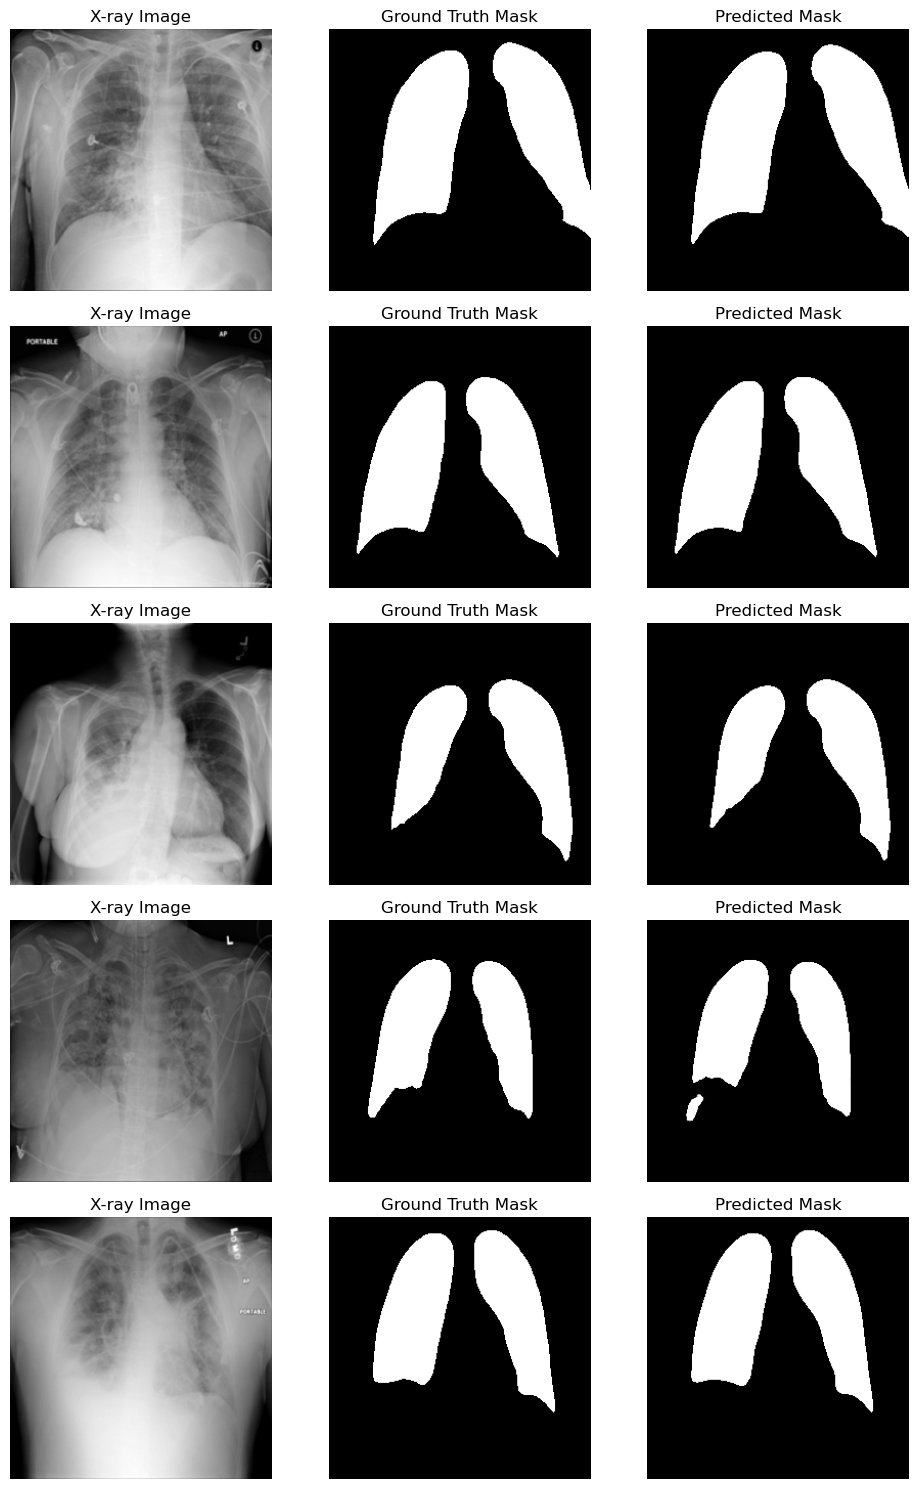

Test Loss: 0.0200 | Test Dice: 0.9798 | Test IoU: 0.9605


In [ ]:


# Set model to evaluation mode
model.eval()
test_loss = 0
dice_metric.reset()
iou_metric.reset()

num_samples = 5  # Number of samples to visualize

fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # Compute metrics
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        
        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

        if i < num_samples:  
            img = images[0].cpu().squeeze().numpy()  
            true_mask = masks[0].cpu().squeeze().numpy()  
            pred_mask = torch.sigmoid(outputs[0]).cpu().squeeze().numpy()  

            axes[i, 0].imshow(img, cmap="gray")
            axes[i, 0].set_title("X-ray Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(true_mask, cmap="gray")
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_mask, cmap="gray")
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Compute average test metrics
test_loss = test_loss / len(test_loader)
test_dice = dice_metric.compute().item()
test_iou = iou_metric.compute().item()

print(f"Test Loss: {test_loss:.4f} | Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")



further tests on model 1

 4 Bilder aus der COVID-Klasse erfolgreich geladen!


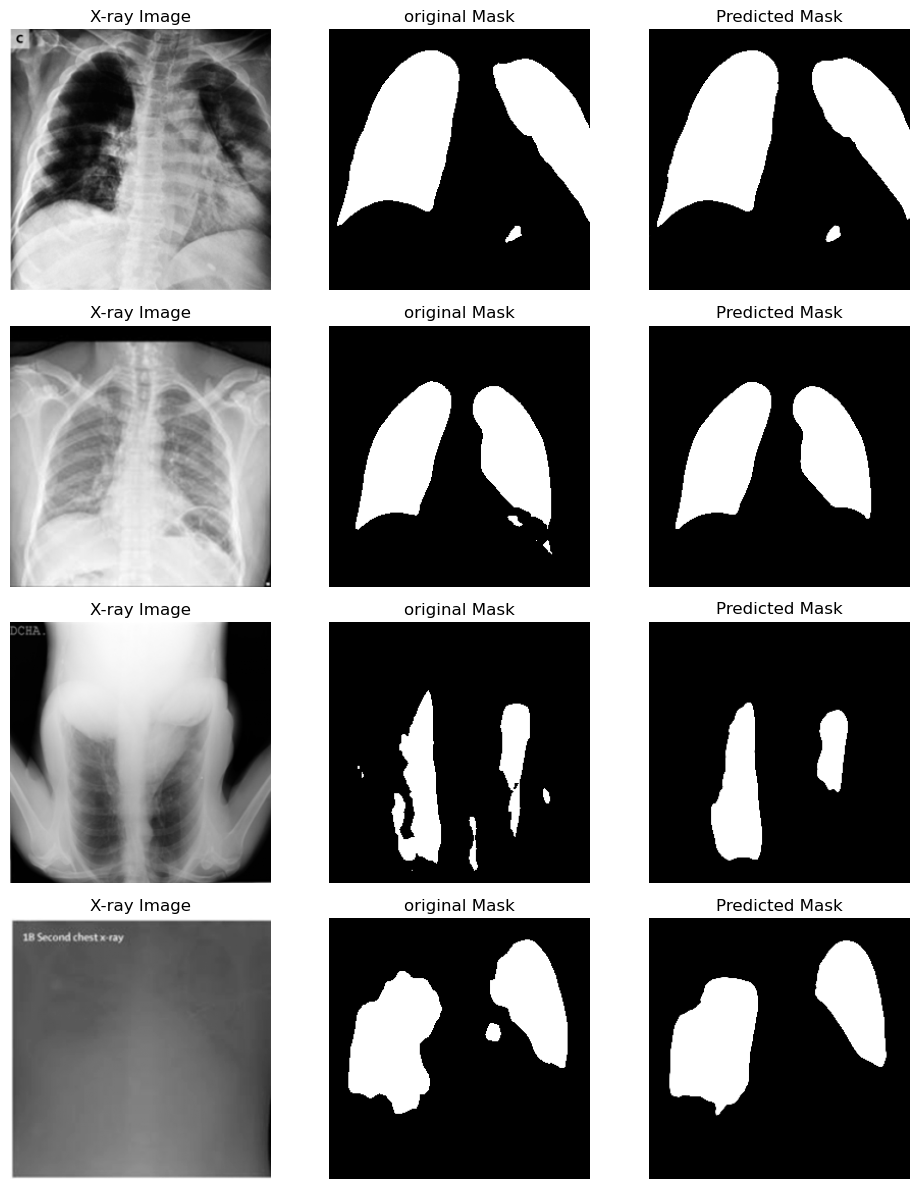

 Test Loss: 0.0629 | Test Dice: 0.9549 | Test IoU: 0.9136


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# **Set device (GPU or CPU)**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Path to the COVID image folder**
base_folder = r"C:\Users\majas\COVIDProjekt\COVID-19_Radiography_Dataset"
covid_image_folder = os.path.join(base_folder, "COVID", "images")
covid_mask_folder = os.path.join(base_folder, "COVID", "masks")

# **List of selected image filenames**
selected_files = ["COVID-8.png", "COVID-171.png", "COVID-257.png", "COVID-698.png"]

# **Transformations for images & masks**
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# **Custom Dataset for selected images**
class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder, selected_files, transform_img=None, transform_mask=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.selected_files = selected_files
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.selected_files)

    def __getitem__(self, idx):
        img_name = self.selected_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        mask_path = os.path.join(self.mask_folder, img_name)  # Assumes mask has the same filename

        # Load image & mask in grayscale
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# **Create dataset & DataLoader**
selected_dataset = CustomDataset(covid_image_folder, covid_mask_folder, selected_files, image_transform, mask_transform)
selected_loader = DataLoader(selected_dataset, batch_size=1, shuffle=False)

print(f"✅ {len(selected_files)} images from the COVID class successfully loaded!")

# **Set model to evaluation mode**
model.eval()
test_loss = 0
dice_metric.reset()
iou_metric.reset()

# **Number of samples to visualize**
num_samples = len(selected_files)

fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

with torch.no_grad():
    for i, (images, masks) in enumerate(selected_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # **Compute loss & metrics**
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

        # **Visualize image, ground truth mask, and predicted mask**
        img = images[0].cpu().squeeze().numpy()
        true_mask = masks[0].cpu().squeeze().numpy()
        pred_mask = torch.sigmoid(outputs[0]).cpu().squeeze().numpy()

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title("X-ray Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

# **Finalize and show plot**
plt.tight_layout()
plt.show()

# **Compute average test metrics**
test_loss = test_loss / len(selected_loader)
test_dice = dice_metric.compute().item()
test_iou = iou_metric.compute().item()

print(f"Test Loss: {test_loss:.4f} | Dice Score: {test_dice:.4f} | IoU: {test_iou:.4f}")


with drop out layer

In [ ]:
import os
import torchvision.transforms as T
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics
import segmentation_models_pytorch as smp

# Output directory for saving predicted masks
output_dir = r"C:\Users\majas\Desktop\COVID\unicorn_masks"
os.makedirs(output_dir, exist_ok=True)  # Create folder if it doesn't exist

# Check if GPU is available and run code on it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the custom model
class CustomUnet(nn.Module):
    def __init__(self, encoder_name="efficientnet-b5", encoder_weights=None, in_channels=1, classes=1, dropout_rate=0.3):
        super(CustomUnet, self).__init__()
        
        # Base UNet from segmentation_models_pytorch
        self.unet = smp.Unet(
            encoder_name=encoder_name,   
            encoder_weights=encoder_weights,  
            in_channels=in_channels,       
            classes=classes               
        )
        
        # Add dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        x = self.unet.encoder(x)  # Encoder pass (returns list of feature maps)
        decoder_output = self.unet.decoder(*x)  # Decoder takes feature maps as input
        decoder_output = self.dropout(decoder_output)  # Apply dropout to decoder output
        x = self.unet.segmentation_head(decoder_output)  # Final segmentation layer
        return x

# Initialize model
model = CustomUnet(
    encoder_name="efficientnet-b5",
    encoder_weights=None,  
    in_channels=1,  
    classes=1,
    dropout_rate=0.3
).to(device)

# Loss function & optimizer
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# Additional metrics (IoU, Dice)
dice_metric = torchmetrics.Dice(threshold=0.5).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# Training settings
num_epochs = 20
best_loss = float("inf")
epochs_no_improve = 0
patience = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    print(f"\n Epoch {epoch+1}/{num_epochs}")

    for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Update metrics
        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Compute training averages
    train_loss = epoch_loss / len(train_loader)
    train_dice = dice_metric.compute().item()
    train_iou = iou_metric.compute().item()

    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(valid_loader, desc="Validating", dynamic_ncols=True)):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Save predicted masks
            pred_mask = torch.sigmoid(outputs) > 0.5  # Binary mask (threshold = 0.5)
            
            for idx in range(pred_mask.shape[0]):  # Iterate over batch dimension
                single_pred = pred_mask[idx].squeeze().cpu().numpy().astype("uint8") * 255  
                
                # Generate file name
                file_name = f"epoch_{epoch:02d}_batch_{i:03d}_mask_{idx}.png"
                file_path = os.path.join(output_dir, file_name)
                
                # Save mask as image
                Image.fromarray(single_pred).save(file_path)

            # Compute validation loss & metrics
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            dice_metric.update(torch.sigmoid(outputs), masks.long())
            iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Compute validation averages
    val_loss = val_loss / len(valid_loader)
    val_dice = dice_metric.compute().item()
    val_iou = iou_metric.compute().item()

    print(f"Validation Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "unicorn.pth")
        print("  New best model saved!")
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve}/{patience} epochs.")

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping
    if epochs_no_improve >= patience:
        print("  Early stopping triggered! No further improvement.")
        break

# Load best model for final evaluation
print("Loading best model for final evaluation...")
model.load_state_dict(torch.load("unicorn.pth"))

# Save final model
final_model_path = "lung_segmentation_5.pth"
torch.save(model.state_dict(), final_model_path)
print(f" Model saved as {final_model_path} & training complete!")



 Epoch 1/20


Train Epoch 1/20: 100%|██████████| 1852/1852 [1:10:04<00:00,  2.27s/it]


Train Loss: 0.0320 | Train Dice: 0.9710 | Train IoU: 0.9437


Validating: 100%|██████████| 530/530 [05:37<00:00,  1.57it/s]


Validation Loss: 0.0427 | Val Dice: 0.9579 | Val IoU: 0.9191
 Neues bestes Modell gespeichert!

 Epoch 2/20


Train Epoch 2/20: 100%|██████████| 1852/1852 [1:07:44<00:00,  2.19s/it]


Train Loss: 0.0162 | Train Dice: 0.9840 | Train IoU: 0.9686


Validating: 100%|██████████| 530/530 [05:30<00:00,  1.61it/s]


Validation Loss: 0.0299 | Val Dice: 0.9704 | Val IoU: 0.9426
 Neues bestes Modell gespeichert!

 Epoch 3/20


Train Epoch 3/20: 100%|██████████| 1852/1852 [1:09:30<00:00,  2.25s/it]


Train Loss: 0.0140 | Train Dice: 0.9862 | Train IoU: 0.9728


Validating: 100%|██████████| 530/530 [05:36<00:00,  1.57it/s]


Validation Loss: 0.0312 | Val Dice: 0.9691 | Val IoU: 0.9400
 Keine Verbesserung für 1/5 Epochen.

 Epoch 4/20


Train Epoch 4/20: 100%|██████████| 1852/1852 [1:09:10<00:00,  2.24s/it]


Train Loss: 0.0127 | Train Dice: 0.9874 | Train IoU: 0.9751


Validating: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0262 | Val Dice: 0.9740 | Val IoU: 0.9494
 Neues bestes Modell gespeichert!

 Epoch 5/20


Train Epoch 5/20: 100%|██████████| 1852/1852 [1:08:59<00:00,  2.24s/it]


Train Loss: 0.0123 | Train Dice: 0.9878 | Train IoU: 0.9759


Validating: 100%|██████████| 530/530 [05:20<00:00,  1.65it/s]


Validation Loss: 0.0282 | Val Dice: 0.9722 | Val IoU: 0.9459
 Keine Verbesserung für 1/5 Epochen.

 Epoch 6/20


Train Epoch 6/20: 100%|██████████| 1852/1852 [1:06:30<00:00,  2.15s/it]


Train Loss: 0.0113 | Train Dice: 0.9888 | Train IoU: 0.9779


Validating: 100%|██████████| 530/530 [05:39<00:00,  1.56it/s]


Validation Loss: 0.0253 | Val Dice: 0.9749 | Val IoU: 0.9510
 Neues bestes Modell gespeichert!

 Epoch 7/20


Train Epoch 7/20: 100%|██████████| 1852/1852 [1:14:23<00:00,  2.41s/it]


Train Loss: 0.0109 | Train Dice: 0.9891 | Train IoU: 0.9785


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0235 | Val Dice: 0.9767 | Val IoU: 0.9545
 Neues bestes Modell gespeichert!

 Epoch 8/20


Train Epoch 8/20: 100%|██████████| 1852/1852 [1:07:32<00:00,  2.19s/it]


Train Loss: 0.0105 | Train Dice: 0.9896 | Train IoU: 0.9794


Validating: 100%|██████████| 530/530 [05:32<00:00,  1.59it/s]


Validation Loss: 0.0244 | Val Dice: 0.9758 | Val IoU: 0.9527
 Keine Verbesserung für 1/5 Epochen.

 Epoch 9/20


Train Epoch 9/20: 100%|██████████| 1852/1852 [1:08:42<00:00,  2.23s/it]


Train Loss: 0.0101 | Train Dice: 0.9900 | Train IoU: 0.9802


Validating: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0215 | Val Dice: 0.9786 | Val IoU: 0.9582
 Neues bestes Modell gespeichert!

 Epoch 10/20


Train Epoch 10/20: 100%|██████████| 1852/1852 [1:08:47<00:00,  2.23s/it]


Train Loss: 0.0097 | Train Dice: 0.9904 | Train IoU: 0.9810


Validating: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0225 | Val Dice: 0.9777 | Val IoU: 0.9564
 Keine Verbesserung für 1/5 Epochen.

 Epoch 11/20


Train Epoch 11/20: 100%|██████████| 1852/1852 [1:08:25<00:00,  2.22s/it]


Train Loss: 0.0093 | Train Dice: 0.9908 | Train IoU: 0.9817


Validating: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0205 | Val Dice: 0.9796 | Val IoU: 0.9600
 Neues bestes Modell gespeichert!

 Epoch 12/20


Train Epoch 12/20: 100%|██████████| 1852/1852 [1:08:37<00:00,  2.22s/it]


Train Loss: 0.0090 | Train Dice: 0.9911 | Train IoU: 0.9823


Validating: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0206 | Val Dice: 0.9796 | Val IoU: 0.9600
 Keine Verbesserung für 1/5 Epochen.

 Epoch 13/20


Train Epoch 13/20: 100%|██████████| 1852/1852 [1:08:46<00:00,  2.23s/it]


Train Loss: 0.0090 | Train Dice: 0.9911 | Train IoU: 0.9823


Validating: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0201 | Val Dice: 0.9801 | Val IoU: 0.9610
 Neues bestes Modell gespeichert!

 Epoch 14/20


Train Epoch 14/20: 100%|██████████| 1852/1852 [1:08:50<00:00,  2.23s/it]


Train Loss: 0.0085 | Train Dice: 0.9916 | Train IoU: 0.9833


Validating: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0193 | Val Dice: 0.9809 | Val IoU: 0.9624
 Neues bestes Modell gespeichert!

 Epoch 15/20


Train Epoch 15/20: 100%|██████████| 1852/1852 [1:08:43<00:00,  2.23s/it]


Train Loss: 0.0083 | Train Dice: 0.9917 | Train IoU: 0.9836


Validating: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0185 | Val Dice: 0.9817 | Val IoU: 0.9640
 Neues bestes Modell gespeichert!

 Epoch 16/20


Train Epoch 16/20: 100%|██████████| 1852/1852 [1:08:38<00:00,  2.22s/it]


Train Loss: 0.0081 | Train Dice: 0.9919 | Train IoU: 0.9840


Validating: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0219 | Val Dice: 0.9783 | Val IoU: 0.9574
 Keine Verbesserung für 1/5 Epochen.

 Epoch 17/20


Train Epoch 17/20: 100%|██████████| 1852/1852 [1:08:31<00:00,  2.22s/it]


Train Loss: 0.0079 | Train Dice: 0.9921 | Train IoU: 0.9844


Validating: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0183 | Val Dice: 0.9818 | Val IoU: 0.9642
 Neues bestes Modell gespeichert!

 Epoch 18/20


Train Epoch 18/20: 100%|██████████| 1852/1852 [1:08:52<00:00,  2.23s/it]


Train Loss: 0.0079 | Train Dice: 0.9922 | Train IoU: 0.9844


Validating: 100%|██████████| 530/530 [05:34<00:00,  1.58it/s]


Validation Loss: 0.0179 | Val Dice: 0.9822 | Val IoU: 0.9650
 Neues bestes Modell gespeichert!

 Epoch 19/20


Train Epoch 19/20: 100%|██████████| 1852/1852 [1:08:20<00:00,  2.21s/it]


Train Loss: 0.0076 | Train Dice: 0.9925 | Train IoU: 0.9851


Validating: 100%|██████████| 530/530 [05:36<00:00,  1.57it/s]


Validation Loss: 0.0183 | Val Dice: 0.9819 | Val IoU: 0.9644
 Keine Verbesserung für 1/5 Epochen.

 Epoch 20/20


Train Epoch 20/20: 100%|██████████| 1852/1852 [1:08:55<00:00,  2.23s/it]


Train Loss: 0.0075 | Train Dice: 0.9925 | Train IoU: 0.9852


Validating: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0182 | Val Dice: 0.9819 | Val IoU: 0.9645
 Keine Verbesserung für 2/5 Epochen.
Lade bestes Modell für finale Evaluation...
 Modell gespeichert als lung_segmentation_5.pth & Training abgeschlossen!


continue training model 1

In [ ]:
import os
import torch
import torch.optim as optim
import torchmetrics
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import numpy as np

# Path to save predicted masks
output_dir = r"C:\Users\majas\Desktop\COVID\saved_masks"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = smp.Unet(
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    in_channels=1,
    classes=1
).to(device)

# Load already trained model weights
model.load_state_dict(torch.load("model_24_2_.pth"))

# Loss function & optimizer
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower learning rate for fine-tuning
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# Additional evaluation metrics
dice_metric = torchmetrics.Dice(threshold=0.5).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# Continue training for 15 additional epochs
num_epochs = 15  # +35 epochs = 50 total
best_loss = float("inf")
epochs_no_improve = 0
patience = 5

for epoch in range(36, 36 + num_epochs):  # Start from epoch 36 up to 50
    model.train()
    epoch_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    print(f"\n Epoch {epoch}/{35 + num_epochs}")

    for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch}/{35 + num_epochs}", dynamic_ncols=True):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Update metrics
        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Calculate training averages
    train_loss = epoch_loss / len(train_loader)
    train_dice = dice_metric.compute().item()
    train_iou = iou_metric.compute().item()

    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(valid_loader, desc="Validating & Saving Masks", dynamic_ncols=True)):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Calculate loss and update metrics
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            dice_metric.update(torch.sigmoid(outputs), masks.long())
            iou_metric.update(torch.sigmoid(outputs), masks.long())

            # Save predictions
            pred_mask = torch.sigmoid(outputs) > 0.5  # Binary thresholding

            for idx in range(pred_mask.shape[0]):  # Iterate over batch
                single_pred = pred_mask[idx].squeeze().cpu().numpy().astype("uint8") * 255
                
                # Generate filename (epoch, batch, index)
                file_name = f"epoch_{epoch:02d}_batch_{batch_idx:03d}_mask_{idx}.png"
                file_path = os.path.join(output_dir, file_name)

                # Save mask as image
                Image.fromarray(single_pred).save(file_path)

    # Calculate validation averages
    val_loss = val_loss / len(valid_loader)
    val_dice = dice_metric.compute().item()
    val_iou = iou_metric.compute().item()

    print(f"Validation Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "model_50_epochs.pth")
        print("  New best model saved!")
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve}/{patience} epochs.")

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping
    if epochs_no_improve >= patience:
        print("  Early stopping triggered! No further improvement.")
        break

# After training: Load best model for final evaluation
print("Loading best model for final evaluation...")
model.load_state_dict(torch.load("model_50_epochs.pth"))

# Save final model
final_model_path = "model_50_epochs.pth"
torch.save(model.state_dict(), final_model_path)
print(f" Model saved as {final_model_path} & training complete!")



 Epoch 36/50


Train Epoch 36/50: 100%|██████████| 1852/1852 [1:08:53<00:00,  2.23s/it]


Train Loss: 0.0077 | Train Dice: 0.9924 | Train IoU: 0.9849


Validating & Saving Masks: 100%|██████████| 530/530 [06:03<00:00,  1.46it/s]


Validation Loss: 0.0166 | Val Dice: 0.9836 | Val IoU: 0.9677
 Neues bestes Modell gespeichert!

 Epoch 37/50


Train Epoch 37/50: 100%|██████████| 1852/1852 [38:12<00:00,  1.24s/it] 


Train Loss: 0.0071 | Train Dice: 0.9930 | Train IoU: 0.9861


Validating & Saving Masks: 100%|██████████| 530/530 [01:42<00:00,  5.15it/s]


Validation Loss: 0.0157 | Val Dice: 0.9845 | Val IoU: 0.9694
 Neues bestes Modell gespeichert!

 Epoch 38/50


Train Epoch 38/50: 100%|██████████| 1852/1852 [24:02<00:00,  1.28it/s]


Train Loss: 0.0068 | Train Dice: 0.9932 | Train IoU: 0.9865


Validating & Saving Masks: 100%|██████████| 530/530 [06:34<00:00,  1.34it/s]


Validation Loss: 0.0160 | Val Dice: 0.9841 | Val IoU: 0.9687
 Keine Verbesserung für 1/5 Epochen.

 Epoch 39/50


Train Epoch 39/50: 100%|██████████| 1852/1852 [1:08:10<00:00,  2.21s/it]


Train Loss: 0.0066 | Train Dice: 0.9935 | Train IoU: 0.9870


Validating & Saving Masks: 100%|██████████| 530/530 [05:34<00:00,  1.59it/s]


Validation Loss: 0.0161 | Val Dice: 0.9840 | Val IoU: 0.9685
 Keine Verbesserung für 2/5 Epochen.

 Epoch 40/50


Train Epoch 40/50: 100%|██████████| 1852/1852 [1:08:57<00:00,  2.23s/it]


Train Loss: 0.0064 | Train Dice: 0.9937 | Train IoU: 0.9874


Validating & Saving Masks: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0157 | Val Dice: 0.9844 | Val IoU: 0.9692
 Keine Verbesserung für 3/5 Epochen.

 Epoch 41/50


Train Epoch 41/50: 100%|██████████| 1852/1852 [1:09:03<00:00,  2.24s/it]


Train Loss: 0.0062 | Train Dice: 0.9938 | Train IoU: 0.9877


Validating & Saving Masks: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0167 | Val Dice: 0.9835 | Val IoU: 0.9675
 Keine Verbesserung für 4/5 Epochen.

 Epoch 42/50


Train Epoch 42/50: 100%|██████████| 1852/1852 [1:08:54<00:00,  2.23s/it]


Train Loss: 0.0057 | Train Dice: 0.9944 | Train IoU: 0.9888


Validating & Saving Masks: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0141 | Val Dice: 0.9860 | Val IoU: 0.9724
 Neues bestes Modell gespeichert!

 Epoch 43/50


Train Epoch 43/50: 100%|██████████| 1852/1852 [1:09:02<00:00,  2.24s/it]


Train Loss: 0.0054 | Train Dice: 0.9946 | Train IoU: 0.9893


Validating & Saving Masks: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0142 | Val Dice: 0.9860 | Val IoU: 0.9723
 Keine Verbesserung für 1/5 Epochen.

 Epoch 44/50


Train Epoch 44/50: 100%|██████████| 1852/1852 [1:08:57<00:00,  2.23s/it]


Train Loss: 0.0053 | Train Dice: 0.9947 | Train IoU: 0.9895


Validating & Saving Masks: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0140 | Val Dice: 0.9861 | Val IoU: 0.9726
 Neues bestes Modell gespeichert!

 Epoch 45/50


Train Epoch 45/50: 100%|██████████| 1852/1852 [1:08:50<00:00,  2.23s/it]


Train Loss: 0.0052 | Train Dice: 0.9948 | Train IoU: 0.9897


Validating & Saving Masks: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0138 | Val Dice: 0.9863 | Val IoU: 0.9730
 Neues bestes Modell gespeichert!

 Epoch 46/50


Train Epoch 46/50: 100%|██████████| 1852/1852 [1:08:57<00:00,  2.23s/it]


Train Loss: 0.0051 | Train Dice: 0.9949 | Train IoU: 0.9899


Validating & Saving Masks: 100%|██████████| 530/530 [05:34<00:00,  1.59it/s]


Validation Loss: 0.0137 | Val Dice: 0.9864 | Val IoU: 0.9732
 Neues bestes Modell gespeichert!

 Epoch 47/50


Train Epoch 47/50: 100%|██████████| 1852/1852 [1:08:24<00:00,  2.22s/it]


Train Loss: 0.0050 | Train Dice: 0.9950 | Train IoU: 0.9900


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0139 | Val Dice: 0.9862 | Val IoU: 0.9729
 Keine Verbesserung für 1/5 Epochen.

 Epoch 48/50


Train Epoch 48/50: 100%|██████████| 1852/1852 [1:02:30<00:00,  2.03s/it]


Train Loss: 0.0050 | Train Dice: 0.9951 | Train IoU: 0.9902


Validating & Saving Masks: 100%|██████████| 530/530 [05:13<00:00,  1.69it/s]


Validation Loss: 0.0138 | Val Dice: 0.9863 | Val IoU: 0.9730
 Keine Verbesserung für 2/5 Epochen.

 Epoch 49/50


Train Epoch 49/50: 100%|██████████| 1852/1852 [1:02:17<00:00,  2.02s/it]


Train Loss: 0.0049 | Train Dice: 0.9951 | Train IoU: 0.9903


Validating & Saving Masks: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0138 | Val Dice: 0.9864 | Val IoU: 0.9731
 Keine Verbesserung für 3/5 Epochen.

 Epoch 50/50


Train Epoch 50/50: 100%|██████████| 1852/1852 [1:02:26<00:00,  2.02s/it]


Train Loss: 0.0048 | Train Dice: 0.9952 | Train IoU: 0.9904


Validating & Saving Masks: 100%|██████████| 530/530 [05:02<00:00,  1.75it/s]


Validation Loss: 0.0134 | Val Dice: 0.9867 | Val IoU: 0.9737
 Neues bestes Modell gespeichert!
Lade bestes Modell für finale Evaluation...
 Modell gespeichert als model_50_epochs.pth & Training abgeschlossen!


another 50 epochs and track with ml flow

In [ ]:
import os
import torch
import torch.optim as optim
import torchmetrics
import segmentation_models_pytorch as smp
import mlflow
import mlflow.pytorch
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import numpy as np

# === MLflow Setup ===
mlflow.set_tracking_uri("./mlruns")  # Local tracking
mlflow.set_experiment("COVID-Segmentation-Training")

# === Output folder for predicted masks ===
output_dir = r"C:\Users\majas\Desktop\COVID\saved_masks"
os.makedirs(output_dir, exist_ok=True)

# === Check for GPU availability ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Model ===
model = smp.Unet(
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    in_channels=1,
    classes=1
).to(device)

# === Load already trained model ===
model.load_state_dict(torch.load("model_50_epochs.pth"))

# === Loss function and optimizer ===
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# === Additional metrics ===
dice_metric = torchmetrics.Dice(threshold=0.5).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# === Continue training for 50 more epochs ===
num_epochs = 50
best_loss = float("inf")
epochs_no_improve = 0
patience = 5

with mlflow.start_run():
    mlflow.log_params({
        "encoder": "efficientnet-b5",
        "learning_rate": 0.0005,
        "epochs": num_epochs,
        "batch_size": len(train_loader.dataset),
        "loss_function": "DiceLoss"
    })

    for epoch in range(51, 51 + num_epochs):
        model.train()
        epoch_loss = 0
        dice_metric.reset()
        iou_metric.reset()

        print(f"\n Epoch {epoch}/{50 + num_epochs}")

        for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch}/{50 + num_epochs}", dynamic_ncols=True):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            dice_metric.update(torch.sigmoid(outputs), masks.long())
            iou_metric.update(torch.sigmoid(outputs), masks.long())

        train_loss = epoch_loss / len(train_loader)
        train_dice = dice_metric.compute().item()
        train_iou = iou_metric.compute().item()

        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_dice": train_dice,
            "train_iou": train_iou
        }, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f}")

        # === Validation ===
        model.eval()
        val_loss = 0
        dice_metric.reset()
        iou_metric.reset()

        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(tqdm(valid_loader, desc="Validating & Saving Masks", dynamic_ncols=True)):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                dice_metric.update(torch.sigmoid(outputs), masks.long())
                iou_metric.update(torch.sigmoid(outputs), masks.long())
                pred_mask = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype("uint8") * 255  
                
                for idx in range(pred_mask.shape[0]):
                    file_name = f"epoch_{epoch:02d}_batch_{batch_idx:03d}_mask_{idx}.png"
                    Image.fromarray(pred_mask[idx].squeeze()).save(os.path.join(output_dir, file_name))

        val_loss /= len(valid_loader)
        val_dice = dice_metric.compute().item()
        val_iou = iou_metric.compute().item()

        mlflow.log_metrics({
            "val_loss": val_loss,
            "val_dice": val_dice,
            "val_iou": val_iou
        }, step=epoch)

        print(f"Validation Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

        # === Save best model ===
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "model_100_epochs.pth")
            mlflow.pytorch.log_model(model, "best_model")
            print(" ✅ New best model saved!")
        else:
            epochs_no_improve += 1
            print(f" No improvement for {epochs_no_improve}/{patience} epochs.")

        scheduler.step(val_loss)

        # === Early stopping ===
        if epochs_no_improve >= patience:
            print(" ⛔ Early stopping triggered! No further improvement.")
            break

    # === Load best model after training ===
    print("Loading best model for final evaluation...")
    model.load_state_dict(torch.load("model_100_epochs.pth"))
    torch.save(model.state_dict(), "model_100_epochs.pth")
    print("✅ Model saved as model_100_epochs.pth & training complete!")

    mlflow.pytorch.log_model(model, "final_model")


2025/03/07 11:30:33 INFO mlflow.tracking.fluent: Experiment with name 'COVID-Segmentation-Training' does not exist. Creating a new experiment.
c:\Users\majas\anaconda3\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



 Epoch 51/100


Train Epoch 51/100: 100%|██████████| 1852/1852 [1:06:18<00:00,  2.15s/it]


Train Loss: 0.0053 | Train Dice: 0.9947 | Train IoU: 0.9895


Validating & Saving Masks: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0144 | Val Dice: 0.9857 | Val IoU: 0.9718


2025/03/07 12:41:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/07 12:42:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 52/100


Train Epoch 52/100: 100%|██████████| 1852/1852 [1:02:53<00:00,  2.04s/it]


Train Loss: 0.0054 | Train Dice: 0.9947 | Train IoU: 0.9894


Validating & Saving Masks: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0155 | Val Dice: 0.9847 | Val IoU: 0.9698
 Keine Verbesserung für 1/5 Epochen.

 Epoch 53/100


Train Epoch 53/100: 100%|██████████| 1852/1852 [1:02:36<00:00,  2.03s/it]


Train Loss: 0.0053 | Train Dice: 0.9947 | Train IoU: 0.9896


Validating & Saving Masks: 100%|██████████| 530/530 [05:02<00:00,  1.75it/s]


Validation Loss: 0.0142 | Val Dice: 0.9860 | Val IoU: 0.9723


2025/03/07 14:57:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/07 14:57:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 54/100


Train Epoch 54/100: 100%|██████████| 1852/1852 [1:01:42<00:00,  2.00s/it]


Train Loss: 0.0053 | Train Dice: 0.9948 | Train IoU: 0.9896


Validating & Saving Masks: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0142 | Val Dice: 0.9859 | Val IoU: 0.9723
 Keine Verbesserung für 1/5 Epochen.

 Epoch 55/100


Train Epoch 55/100: 100%|██████████| 1852/1852 [1:02:02<00:00,  2.01s/it]


Train Loss: 0.0053 | Train Dice: 0.9947 | Train IoU: 0.9895


Validating & Saving Masks: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0143 | Val Dice: 0.9858 | Val IoU: 0.9719
 Keine Verbesserung für 2/5 Epochen.

 Epoch 56/100


Train Epoch 56/100: 100%|██████████| 1852/1852 [1:04:10<00:00,  2.08s/it]


Train Loss: 0.0051 | Train Dice: 0.9949 | Train IoU: 0.9898


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.61it/s]


Validation Loss: 0.0143 | Val Dice: 0.9858 | Val IoU: 0.9721
 Keine Verbesserung für 3/5 Epochen.

 Epoch 57/100


Train Epoch 57/100: 100%|██████████| 1852/1852 [1:03:20<00:00,  2.05s/it]


Train Loss: 0.0051 | Train Dice: 0.9950 | Train IoU: 0.9900


Validating & Saving Masks: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0139 | Val Dice: 0.9862 | Val IoU: 0.9728


2025/03/07 19:29:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/07 19:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 58/100


Train Epoch 58/100: 100%|██████████| 1852/1852 [1:01:18<00:00,  1.99s/it]


Train Loss: 0.0050 | Train Dice: 0.9950 | Train IoU: 0.9900


Validating & Saving Masks: 100%|██████████| 530/530 [05:28<00:00,  1.61it/s]


Validation Loss: 0.0142 | Val Dice: 0.9859 | Val IoU: 0.9723
 Keine Verbesserung für 1/5 Epochen.

 Epoch 59/100


Train Epoch 59/100: 100%|██████████| 1852/1852 [1:00:04<00:00,  1.95s/it]


Train Loss: 0.0050 | Train Dice: 0.9950 | Train IoU: 0.9901


Validating & Saving Masks: 100%|██████████| 530/530 [05:03<00:00,  1.74it/s]


Validation Loss: 0.0138 | Val Dice: 0.9863 | Val IoU: 0.9731


2025/03/07 21:41:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/07 21:42:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 60/100


Train Epoch 60/100: 100%|██████████| 1852/1852 [1:07:57<00:00,  2.20s/it]


Train Loss: 0.0049 | Train Dice: 0.9951 | Train IoU: 0.9902


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0143 | Val Dice: 0.9858 | Val IoU: 0.9721
 Keine Verbesserung für 1/5 Epochen.

 Epoch 61/100


Train Epoch 61/100: 100%|██████████| 1852/1852 [1:08:21<00:00,  2.21s/it]


Train Loss: 0.0049 | Train Dice: 0.9951 | Train IoU: 0.9903


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.61it/s]


Validation Loss: 0.0138 | Val Dice: 0.9863 | Val IoU: 0.9730
 Keine Verbesserung für 2/5 Epochen.

 Epoch 62/100


Train Epoch 62/100: 100%|██████████| 1852/1852 [1:08:21<00:00,  2.21s/it]


Train Loss: 0.0048 | Train Dice: 0.9952 | Train IoU: 0.9905


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.61it/s]


Validation Loss: 0.0140 | Val Dice: 0.9861 | Val IoU: 0.9726
 Keine Verbesserung für 3/5 Epochen.

 Epoch 63/100


Train Epoch 63/100: 100%|██████████| 1852/1852 [1:08:15<00:00,  2.21s/it]


Train Loss: 0.0048 | Train Dice: 0.9952 | Train IoU: 0.9905


Validating & Saving Masks: 100%|██████████| 530/530 [05:29<00:00,  1.61it/s]


Validation Loss: 0.0139 | Val Dice: 0.9862 | Val IoU: 0.9729
 Keine Verbesserung für 4/5 Epochen.

 Epoch 64/100


Train Epoch 64/100: 100%|██████████| 1852/1852 [1:08:14<00:00,  2.21s/it]


Train Loss: 0.0044 | Train Dice: 0.9957 | Train IoU: 0.9914


Validating & Saving Masks: 100%|██████████| 530/530 [05:29<00:00,  1.61it/s]


Validation Loss: 0.0132 | Val Dice: 0.9869 | Val IoU: 0.9741


2025/03/08 03:50:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 03:50:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 65/100


Train Epoch 65/100: 100%|██████████| 1852/1852 [1:08:07<00:00,  2.21s/it]


Train Loss: 0.0042 | Train Dice: 0.9958 | Train IoU: 0.9917


Validating & Saving Masks: 100%|██████████| 530/530 [05:29<00:00,  1.61it/s]


Validation Loss: 0.0132 | Val Dice: 0.9869 | Val IoU: 0.9742


2025/03/08 05:04:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 05:04:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 66/100


Train Epoch 66/100: 100%|██████████| 1852/1852 [1:08:01<00:00,  2.20s/it]


Train Loss: 0.0041 | Train Dice: 0.9959 | Train IoU: 0.9918


Validating & Saving Masks: 100%|██████████| 530/530 [05:29<00:00,  1.61it/s]


Validation Loss: 0.0131 | Val Dice: 0.9870 | Val IoU: 0.9743


2025/03/08 06:18:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 06:18:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 67/100


Train Epoch 67/100: 100%|██████████| 1852/1852 [1:08:04<00:00,  2.21s/it]


Train Loss: 0.0041 | Train Dice: 0.9959 | Train IoU: 0.9919


Validating & Saving Masks: 100%|██████████| 530/530 [05:29<00:00,  1.61it/s]


Validation Loss: 0.0132 | Val Dice: 0.9869 | Val IoU: 0.9742
 Keine Verbesserung für 1/5 Epochen.

 Epoch 68/100


Train Epoch 68/100: 100%|██████████| 1852/1852 [1:08:19<00:00,  2.21s/it]


Train Loss: 0.0041 | Train Dice: 0.9960 | Train IoU: 0.9919


Validating & Saving Masks: 100%|██████████| 530/530 [05:29<00:00,  1.61it/s]


Validation Loss: 0.0131 | Val Dice: 0.9870 | Val IoU: 0.9744


2025/03/08 08:45:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 08:46:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 69/100


Train Epoch 69/100: 100%|██████████| 1852/1852 [1:01:42<00:00,  2.00s/it]


Train Loss: 0.0040 | Train Dice: 0.9960 | Train IoU: 0.9920


Validating & Saving Masks: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0132 | Val Dice: 0.9869 | Val IoU: 0.9742
 Keine Verbesserung für 1/5 Epochen.

 Epoch 70/100


Train Epoch 70/100: 100%|██████████| 1852/1852 [1:02:10<00:00,  2.01s/it]


Train Loss: 0.0040 | Train Dice: 0.9960 | Train IoU: 0.9921


Validating & Saving Masks: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0130 | Val Dice: 0.9871 | Val IoU: 0.9745


2025/03/08 11:00:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 11:00:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 71/100


Train Epoch 71/100: 100%|██████████| 1852/1852 [1:01:28<00:00,  1.99s/it]


Train Loss: 0.0040 | Train Dice: 0.9960 | Train IoU: 0.9921


Validating & Saving Masks: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0130 | Val Dice: 0.9871 | Val IoU: 0.9745


2025/03/08 12:06:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 12:06:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 72/100


Train Epoch 72/100: 100%|██████████| 1852/1852 [1:01:49<00:00,  2.00s/it]


Train Loss: 0.0039 | Train Dice: 0.9961 | Train IoU: 0.9922


Validating & Saving Masks: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0131 | Val Dice: 0.9870 | Val IoU: 0.9743
 Keine Verbesserung für 1/5 Epochen.

 Epoch 73/100


Train Epoch 73/100: 100%|██████████| 1852/1852 [1:01:53<00:00,  2.01s/it]


Train Loss: 0.0039 | Train Dice: 0.9961 | Train IoU: 0.9922


Validating & Saving Masks: 100%|██████████| 530/530 [05:07<00:00,  1.72it/s]


Validation Loss: 0.0130 | Val Dice: 0.9871 | Val IoU: 0.9745
 Keine Verbesserung für 2/5 Epochen.

 Epoch 74/100


Train Epoch 74/100: 100%|██████████| 1852/1852 [1:02:12<00:00,  2.02s/it]


Train Loss: 0.0039 | Train Dice: 0.9961 | Train IoU: 0.9923


Validating & Saving Masks: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0132 | Val Dice: 0.9869 | Val IoU: 0.9742
 Keine Verbesserung für 3/5 Epochen.

 Epoch 75/100


Train Epoch 75/100: 100%|██████████| 1852/1852 [1:03:24<00:00,  2.05s/it]


Train Loss: 0.0039 | Train Dice: 0.9961 | Train IoU: 0.9923


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.61it/s]


Validation Loss: 0.0130 | Val Dice: 0.9871 | Val IoU: 0.9745
 Keine Verbesserung für 4/5 Epochen.

 Epoch 76/100


Train Epoch 76/100: 100%|██████████| 1852/1852 [1:04:19<00:00,  2.08s/it]


Train Loss: 0.0037 | Train Dice: 0.9964 | Train IoU: 0.9927


Validating & Saving Masks: 100%|██████████| 530/530 [05:35<00:00,  1.58it/s]


Validation Loss: 0.0129 | Val Dice: 0.9872 | Val IoU: 0.9748


2025/03/08 17:46:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 17:47:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 77/100


Train Epoch 77/100: 100%|██████████| 1852/1852 [1:08:14<00:00,  2.21s/it]


Train Loss: 0.0036 | Train Dice: 0.9964 | Train IoU: 0.9929


Validating & Saving Masks: 100%|██████████| 530/530 [06:44<00:00,  1.31it/s]


Validation Loss: 0.0127 | Val Dice: 0.9874 | Val IoU: 0.9751


2025/03/08 19:02:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 19:02:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 78/100


Train Epoch 78/100: 100%|██████████| 1852/1852 [1:02:13<00:00,  2.02s/it]


Train Loss: 0.0036 | Train Dice: 0.9965 | Train IoU: 0.9929


Validating & Saving Masks: 100%|██████████| 530/530 [05:06<00:00,  1.73it/s]


Validation Loss: 0.0128 | Val Dice: 0.9873 | Val IoU: 0.9749
 Keine Verbesserung für 1/5 Epochen.

 Epoch 79/100


Train Epoch 79/100: 100%|██████████| 1852/1852 [1:02:47<00:00,  2.03s/it]


Train Loss: 0.0035 | Train Dice: 0.9965 | Train IoU: 0.9930


Validating & Saving Masks: 100%|██████████| 530/530 [05:07<00:00,  1.73it/s]


Validation Loss: 0.0128 | Val Dice: 0.9873 | Val IoU: 0.9750
 Keine Verbesserung für 2/5 Epochen.

 Epoch 80/100


Train Epoch 80/100: 100%|██████████| 1852/1852 [1:04:16<00:00,  2.08s/it]


Train Loss: 0.0035 | Train Dice: 0.9965 | Train IoU: 0.9930


Validating & Saving Masks: 100%|██████████| 530/530 [05:32<00:00,  1.59it/s]


Validation Loss: 0.0128 | Val Dice: 0.9873 | Val IoU: 0.9750
 Keine Verbesserung für 3/5 Epochen.

 Epoch 81/100


Train Epoch 81/100: 100%|██████████| 1852/1852 [1:08:20<00:00,  2.21s/it]


Train Loss: 0.0035 | Train Dice: 0.9965 | Train IoU: 0.9931


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0127 | Val Dice: 0.9874 | Val IoU: 0.9752


2025/03/08 23:41:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/08 23:41:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Neues bestes Modell gespeichert!

 Epoch 82/100


Train Epoch 82/100: 100%|██████████| 1852/1852 [1:08:14<00:00,  2.21s/it]


Train Loss: 0.0035 | Train Dice: 0.9965 | Train IoU: 0.9931


Validating & Saving Masks: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0127 | Val Dice: 0.9874 | Val IoU: 0.9751
 Keine Verbesserung für 1/5 Epochen.

 Epoch 83/100


Train Epoch 83/100: 100%|██████████| 1852/1852 [1:08:27<00:00,  2.22s/it]


Train Loss: 0.0035 | Train Dice: 0.9966 | Train IoU: 0.9932


Validating & Saving Masks: 100%|██████████| 530/530 [05:30<00:00,  1.60it/s]


Validation Loss: 0.0129 | Val Dice: 0.9872 | Val IoU: 0.9747
 Keine Verbesserung für 2/5 Epochen.

 Epoch 84/100


Train Epoch 84/100: 100%|██████████| 1852/1852 [1:08:25<00:00,  2.22s/it]


Train Loss: 0.0035 | Train Dice: 0.9966 | Train IoU: 0.9932


Validating & Saving Masks: 100%|██████████| 530/530 [05:26<00:00,  1.62it/s]


Validation Loss: 0.0129 | Val Dice: 0.9872 | Val IoU: 0.9748
 Keine Verbesserung für 3/5 Epochen.

 Epoch 85/100


Train Epoch 85/100: 100%|██████████| 1852/1852 [1:08:24<00:00,  2.22s/it]


Train Loss: 0.0034 | Train Dice: 0.9966 | Train IoU: 0.9932


Validating & Saving Masks: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0128 | Val Dice: 0.9873 | Val IoU: 0.9750
 Keine Verbesserung für 4/5 Epochen.

 Epoch 86/100


Train Epoch 86/100: 100%|██████████| 1852/1852 [1:08:31<00:00,  2.22s/it]


Train Loss: 0.0033 | Train Dice: 0.9967 | Train IoU: 0.9934


Validating & Saving Masks: 100%|██████████| 530/530 [05:16<00:00,  1.67it/s]


Validation Loss: 0.0127 | Val Dice: 0.9874 | Val IoU: 0.9751
 Keine Verbesserung für 5/5 Epochen.
 Early Stopping ausgelöst! Kein Fortschritt mehr.
Lade bestes Modell für finale Evaluation...
 Modell gespeichert als model_100_epochs.pth & Training abgeschlossen!


2025/03/09 05:50:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/09 05:50:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


test model

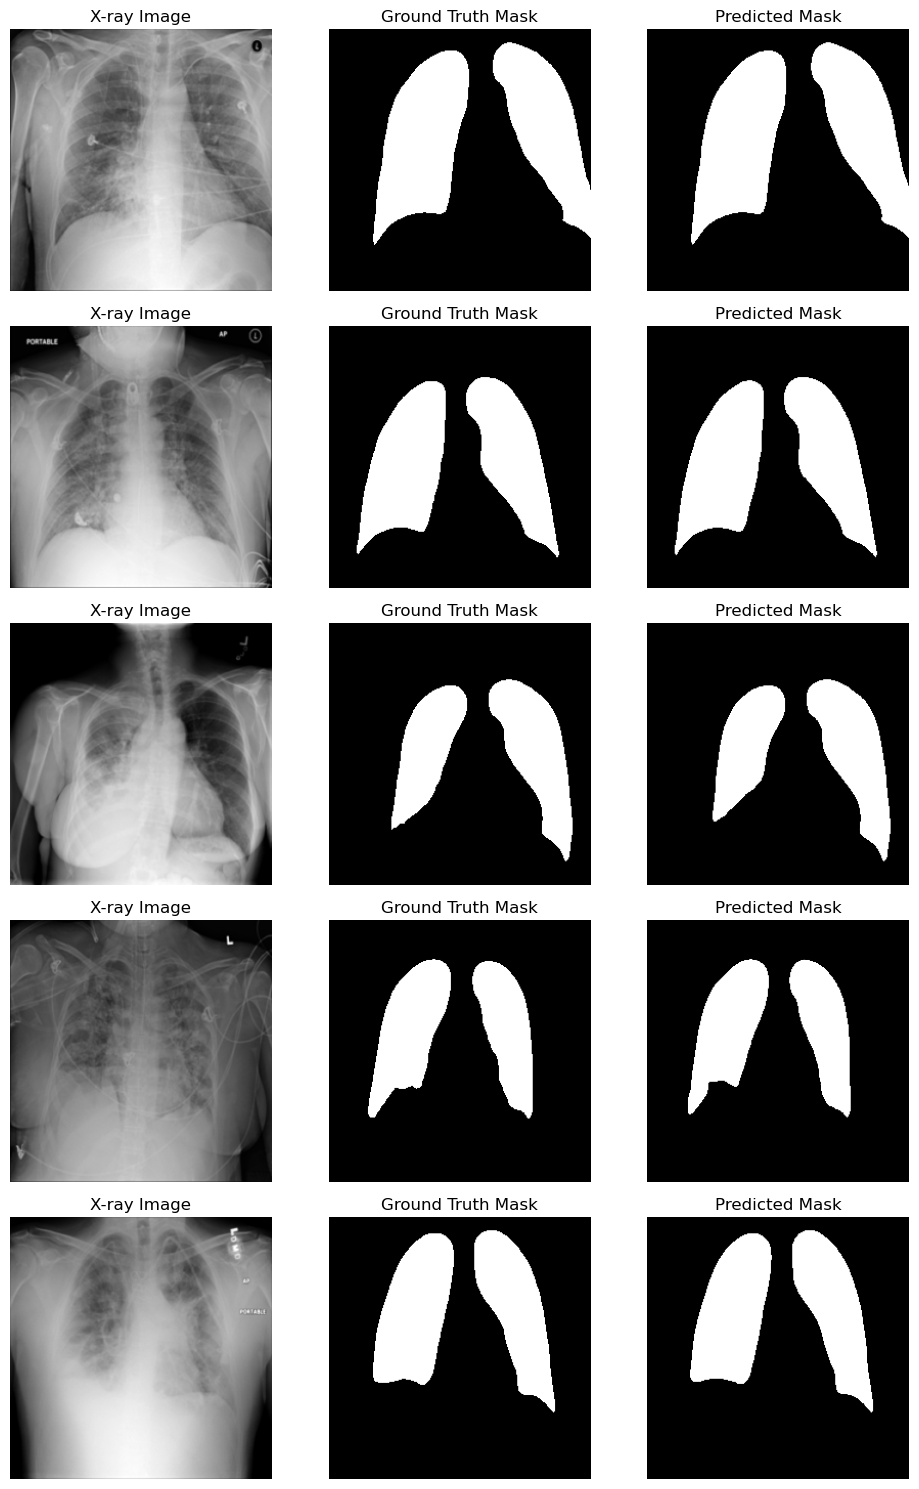


🔍 Test-Ergebnisse:
Test Loss: 0.0164 | Dice Score: 0.9834 | IoU: 0.9674


In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
test_loss = 0
dice_metric.reset()
iou_metric.reset()

num_samples = 5  # Number of test images to visualize
fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # Compute metrics
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

        # Visualize the first `num_samples` images
        if i < num_samples:
            img = images[0].cpu().squeeze().numpy()
            true_mask = masks[0].cpu().squeeze().numpy()
            pred_mask = torch.sigmoid(outputs[0]).cpu().squeeze().numpy()

            axes[i, 0].imshow(img, cmap="gray")
            axes[i, 0].set_title("X-ray Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(true_mask, cmap="gray")
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_mask, cmap="gray")
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Compute average test metrics
test_loss = test_loss / len(test_loader)
test_dice = dice_metric.compute().item()
test_iou = iou_metric.compute().item()

print(f"\n Test Results:")
print(f"Test Loss: {test_loss:.4f} | Dice Score: {test_dice:.4f} | IoU: {test_iou:.4f}")


Continue training the model with a dropout layer

In [ ]:
import os
import torchvision.transforms as T
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics
import segmentation_models_pytorch as smp

# Output directory for predicted masks
output_dir = r"C:\Users\majas\Desktop\COVID\unicorn_masks"
os.makedirs(output_dir, exist_ok=True)  # Create folder if it doesn't exist

# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CustomUnet(nn.Module):
    # Define main model parameters
    def __init__(self, encoder_name="efficientnet-b5", encoder_weights=None, in_channels=1, classes=1, dropout_rate=0.3):
        super(CustomUnet, self).__init__()
        
        # Base UNet from segmentation_models_pytorch
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        )
        
        # Add dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        x = self.unet.encoder(x)  # Encoder pass (returns list of feature maps)
        decoder_output = self.unet.decoder(*x)  # Decoder uses feature maps as input
        decoder_output = self.dropout(decoder_output)  # Apply dropout to decoder output
        x = self.unet.segmentation_head(decoder_output)  # Final segmentation layer
        return x

# Initialize model
model = CustomUnet(
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    in_channels=1,
    classes=1,
    dropout_rate=0.3
).to(device)

# Loss function & optimizer
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# Additional metrics (IoU, Dice Score)
dice_metric = torchmetrics.Dice(threshold=0.5).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# Training configuration
num_epochs = 100
best_loss = float("inf")
epochs_no_improve = 0
patience = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    print(f"\n Epoch {epoch+1}/{num_epochs}")

    for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Update metrics
        dice_metric.update(torch.sigmoid(outputs), masks.long())
        iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Calculate training averages
    train_loss = epoch_loss / len(train_loader)
    train_dice = dice_metric.compute().item()
    train_iou = iou_metric.compute().item()

    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | Train IoU: {train_iou:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    dice_metric.reset()
    iou_metric.reset()

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(valid_loader, desc="Validating", dynamic_ncols=True)):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Save predicted masks
            pred_mask = torch.sigmoid(outputs) > 0.5  # Create binary mask (threshold 0.5)
            
            for idx in range(pred_mask.shape[0]):
                single_pred = pred_mask[idx].squeeze().cpu().numpy().astype("uint8") * 255
                
                # Generate filename
                file_name = f"epoch_{epoch:02d}_batch_{i:03d}_mask_{idx}.png"
                file_path = os.path.join(output_dir, file_name)
                
                # Save mask as image
                Image.fromarray(single_pred).save(file_path)

            # Calculate loss & metrics
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            dice_metric.update(torch.sigmoid(outputs), masks.long())
            iou_metric.update(torch.sigmoid(outputs), masks.long())

    # Validation averages
    val_loss = val_loss / len(valid_loader)
    val_dice = dice_metric.compute().item()
    val_iou = iou_metric.compute().item()

    print(f"Validation Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "unicorn.pth")
        print(" New best model saved!")
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve}/{patience} epochs.")

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping
    if epochs_no_improve >= patience:
        print(" Early stopping triggered! No further improvement.")
        break

# After training: Load best model
print("Loading best model for final evaluation...")
model.load_state_dict(torch.load(""))

# Save model
final_model_path = "lung_segmentation_5.pth"
torch.save(model.state_dict(), final_model_path)
print(f" Model saved as {final_model_path} & training completed!")



 Epoch 1/100


Train Epoch 1/100: 100%|██████████| 1852/1852 [1:06:14<00:00,  2.15s/it]


Train Loss: 0.0328 | Train Dice: 0.9701 | Train IoU: 0.9420


Validating: 100%|██████████| 530/530 [05:04<00:00,  1.74it/s]


Validation Loss: 0.0454 | Val Dice: 0.9552 | Val IoU: 0.9142
 Neues bestes Modell gespeichert!

 Epoch 2/100


Train Epoch 2/100: 100%|██████████| 1852/1852 [1:02:19<00:00,  2.02s/it]


Train Loss: 0.0156 | Train Dice: 0.9846 | Train IoU: 0.9697


Validating: 100%|██████████| 530/530 [05:04<00:00,  1.74it/s]


Validation Loss: 0.0380 | Val Dice: 0.9624 | Val IoU: 0.9275
 Neues bestes Modell gespeichert!

 Epoch 3/100


Train Epoch 3/100: 100%|██████████| 1852/1852 [1:02:03<00:00,  2.01s/it]


Train Loss: 0.0139 | Train Dice: 0.9863 | Train IoU: 0.9729


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0266 | Val Dice: 0.9737 | Val IoU: 0.9488
 Neues bestes Modell gespeichert!

 Epoch 4/100


Train Epoch 4/100: 100%|██████████| 1852/1852 [1:02:51<00:00,  2.04s/it]


Train Loss: 0.0129 | Train Dice: 0.9872 | Train IoU: 0.9748


Validating: 100%|██████████| 530/530 [05:05<00:00,  1.74it/s]


Validation Loss: 0.0277 | Val Dice: 0.9725 | Val IoU: 0.9466
 Keine Verbesserung für 1/5 Epochen.

 Epoch 5/100


Train Epoch 5/100: 100%|██████████| 1852/1852 [1:02:26<00:00,  2.02s/it]


Train Loss: 0.0117 | Train Dice: 0.9884 | Train IoU: 0.9770


Validating: 100%|██████████| 530/530 [05:02<00:00,  1.75it/s]


Validation Loss: 0.0249 | Val Dice: 0.9754 | Val IoU: 0.9519
 Neues bestes Modell gespeichert!

 Epoch 6/100


Train Epoch 6/100: 100%|██████████| 1852/1852 [1:01:38<00:00,  2.00s/it]


Train Loss: 0.0114 | Train Dice: 0.9887 | Train IoU: 0.9776


Validating: 100%|██████████| 530/530 [02:44<00:00,  3.22it/s]


Validation Loss: 0.0236 | Val Dice: 0.9766 | Val IoU: 0.9542
 Neues bestes Modell gespeichert!

 Epoch 7/100


Train Epoch 7/100: 100%|██████████| 1852/1852 [44:02<00:00,  1.43s/it] 


Train Loss: 0.0104 | Train Dice: 0.9896 | Train IoU: 0.9795


Validating: 100%|██████████| 530/530 [05:07<00:00,  1.73it/s]


Validation Loss: 0.0234 | Val Dice: 0.9768 | Val IoU: 0.9546
 Neues bestes Modell gespeichert!

 Epoch 8/100


Train Epoch 8/100: 100%|██████████| 1852/1852 [23:57<00:00,  1.29it/s] 


Train Loss: 0.0103 | Train Dice: 0.9897 | Train IoU: 0.9797


Validating: 100%|██████████| 530/530 [01:47<00:00,  4.94it/s]


Validation Loss: 0.0224 | Val Dice: 0.9778 | Val IoU: 0.9566
 Neues bestes Modell gespeichert!

 Epoch 9/100


Train Epoch 9/100: 100%|██████████| 1852/1852 [18:17<00:00,  1.69it/s]


Train Loss: 0.0099 | Train Dice: 0.9901 | Train IoU: 0.9805


Validating: 100%|██████████| 530/530 [03:19<00:00,  2.65it/s]


Validation Loss: 0.0204 | Val Dice: 0.9798 | Val IoU: 0.9604
 Neues bestes Modell gespeichert!

 Epoch 10/100


Train Epoch 10/100: 100%|██████████| 1852/1852 [29:13<00:00,  1.06it/s]


Train Loss: 0.0095 | Train Dice: 0.9906 | Train IoU: 0.9814


Validating: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0230 | Val Dice: 0.9771 | Val IoU: 0.9553
 Keine Verbesserung für 1/5 Epochen.

 Epoch 11/100


Train Epoch 11/100: 100%|██████████| 1852/1852 [1:01:40<00:00,  2.00s/it]


Train Loss: 0.0093 | Train Dice: 0.9907 | Train IoU: 0.9817


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0202 | Val Dice: 0.9800 | Val IoU: 0.9608
 Neues bestes Modell gespeichert!

 Epoch 12/100


Train Epoch 12/100: 100%|██████████| 1852/1852 [1:01:55<00:00,  2.01s/it]


Train Loss: 0.0088 | Train Dice: 0.9912 | Train IoU: 0.9826


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0193 | Val Dice: 0.9809 | Val IoU: 0.9625
 Neues bestes Modell gespeichert!

 Epoch 13/100


Train Epoch 13/100: 100%|██████████| 1852/1852 [1:01:56<00:00,  2.01s/it]


Train Loss: 0.0088 | Train Dice: 0.9913 | Train IoU: 0.9827


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0191 | Val Dice: 0.9811 | Val IoU: 0.9629
 Neues bestes Modell gespeichert!

 Epoch 14/100


Train Epoch 14/100: 100%|██████████| 1852/1852 [1:01:57<00:00,  2.01s/it]


Train Loss: 0.0085 | Train Dice: 0.9916 | Train IoU: 0.9833


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0183 | Val Dice: 0.9819 | Val IoU: 0.9644
 Neues bestes Modell gespeichert!

 Epoch 15/100


Train Epoch 15/100: 100%|██████████| 1852/1852 [1:01:39<00:00,  2.00s/it]


Train Loss: 0.0083 | Train Dice: 0.9918 | Train IoU: 0.9837


Validating: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0191 | Val Dice: 0.9810 | Val IoU: 0.9627
 Keine Verbesserung für 1/5 Epochen.

 Epoch 16/100


Train Epoch 16/100: 100%|██████████| 1852/1852 [1:01:55<00:00,  2.01s/it]


Train Loss: 0.0081 | Train Dice: 0.9920 | Train IoU: 0.9841


Validating: 100%|██████████| 530/530 [04:59<00:00,  1.77it/s]


Validation Loss: 0.0189 | Val Dice: 0.9813 | Val IoU: 0.9632
 Keine Verbesserung für 2/5 Epochen.

 Epoch 17/100


Train Epoch 17/100: 100%|██████████| 1852/1852 [1:01:56<00:00,  2.01s/it]


Train Loss: 0.0080 | Train Dice: 0.9921 | Train IoU: 0.9843


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0188 | Val Dice: 0.9814 | Val IoU: 0.9634
 Keine Verbesserung für 3/5 Epochen.

 Epoch 18/100


Train Epoch 18/100: 100%|██████████| 1852/1852 [1:01:55<00:00,  2.01s/it]


Train Loss: 0.0077 | Train Dice: 0.9924 | Train IoU: 0.9849


Validating: 100%|██████████| 530/530 [04:56<00:00,  1.79it/s]


Validation Loss: 0.0257 | Val Dice: 0.9745 | Val IoU: 0.9503
 Keine Verbesserung für 4/5 Epochen.

 Epoch 19/100


Train Epoch 19/100: 100%|██████████| 1852/1852 [1:01:51<00:00,  2.00s/it]


Train Loss: 0.0070 | Train Dice: 0.9931 | Train IoU: 0.9862


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0164 | Val Dice: 0.9838 | Val IoU: 0.9681
 Neues bestes Modell gespeichert!

 Epoch 20/100


Train Epoch 20/100: 100%|██████████| 1852/1852 [1:01:50<00:00,  2.00s/it]


Train Loss: 0.0066 | Train Dice: 0.9935 | Train IoU: 0.9870


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0167 | Val Dice: 0.9834 | Val IoU: 0.9674
 Keine Verbesserung für 1/5 Epochen.

 Epoch 21/100


Train Epoch 21/100: 100%|██████████| 1852/1852 [1:01:56<00:00,  2.01s/it]


Train Loss: 0.0065 | Train Dice: 0.9936 | Train IoU: 0.9872


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0173 | Val Dice: 0.9828 | Val IoU: 0.9663
 Keine Verbesserung für 2/5 Epochen.

 Epoch 22/100


Train Epoch 22/100: 100%|██████████| 1852/1852 [1:01:36<00:00,  2.00s/it]


Train Loss: 0.0064 | Train Dice: 0.9937 | Train IoU: 0.9875


Validating: 100%|██████████| 530/530 [04:56<00:00,  1.79it/s]


Validation Loss: 0.0162 | Val Dice: 0.9839 | Val IoU: 0.9683
 Neues bestes Modell gespeichert!

 Epoch 23/100


Train Epoch 23/100: 100%|██████████| 1852/1852 [1:08:13<00:00,  2.21s/it]


Train Loss: 0.0062 | Train Dice: 0.9938 | Train IoU: 0.9877


Validating: 100%|██████████| 530/530 [05:38<00:00,  1.57it/s]


Validation Loss: 0.0161 | Val Dice: 0.9841 | Val IoU: 0.9686
 Neues bestes Modell gespeichert!

 Epoch 24/100


Train Epoch 24/100: 100%|██████████| 1852/1852 [1:07:40<00:00,  2.19s/it]


Train Loss: 0.0062 | Train Dice: 0.9939 | Train IoU: 0.9878


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0157 | Val Dice: 0.9844 | Val IoU: 0.9694
 Neues bestes Modell gespeichert!

 Epoch 25/100


Train Epoch 25/100: 100%|██████████| 1852/1852 [1:03:29<00:00,  2.06s/it]


Train Loss: 0.0061 | Train Dice: 0.9939 | Train IoU: 0.9879


Validating: 100%|██████████| 530/530 [05:38<00:00,  1.57it/s]


Validation Loss: 0.0155 | Val Dice: 0.9846 | Val IoU: 0.9697
 Neues bestes Modell gespeichert!

 Epoch 26/100


Train Epoch 26/100: 100%|██████████| 1852/1852 [1:10:20<00:00,  2.28s/it]


Train Loss: 0.0060 | Train Dice: 0.9940 | Train IoU: 0.9882


Validating: 100%|██████████| 530/530 [05:49<00:00,  1.52it/s]


Validation Loss: 0.0157 | Val Dice: 0.9844 | Val IoU: 0.9693
 Keine Verbesserung für 1/5 Epochen.

 Epoch 27/100


Train Epoch 27/100: 100%|██████████| 1852/1852 [1:04:41<00:00,  2.10s/it]


Train Loss: 0.0059 | Train Dice: 0.9941 | Train IoU: 0.9883


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0158 | Val Dice: 0.9843 | Val IoU: 0.9691
 Keine Verbesserung für 2/5 Epochen.

 Epoch 28/100


Train Epoch 28/100: 100%|██████████| 1852/1852 [1:01:54<00:00,  2.01s/it]


Train Loss: 0.0059 | Train Dice: 0.9942 | Train IoU: 0.9884


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0156 | Val Dice: 0.9845 | Val IoU: 0.9695
 Keine Verbesserung für 3/5 Epochen.

 Epoch 29/100


Train Epoch 29/100: 100%|██████████| 1852/1852 [1:01:53<00:00,  2.01s/it]


Train Loss: 0.0058 | Train Dice: 0.9942 | Train IoU: 0.9885


Validating: 100%|██████████| 530/530 [05:01<00:00,  1.76it/s]


Validation Loss: 0.0156 | Val Dice: 0.9845 | Val IoU: 0.9694
 Keine Verbesserung für 4/5 Epochen.

 Epoch 30/100


Train Epoch 30/100: 100%|██████████| 1852/1852 [1:01:44<00:00,  2.00s/it]


Train Loss: 0.0054 | Train Dice: 0.9946 | Train IoU: 0.9893


Validating: 100%|██████████| 530/530 [03:39<00:00,  2.42it/s]


Validation Loss: 0.0150 | Val Dice: 0.9851 | Val IoU: 0.9706
 Neues bestes Modell gespeichert!

 Epoch 31/100


Train Epoch 31/100: 100%|██████████| 1852/1852 [1:07:23<00:00,  2.18s/it]


Train Loss: 0.0053 | Train Dice: 0.9948 | Train IoU: 0.9896


Validating: 100%|██████████| 530/530 [05:23<00:00,  1.64it/s]


Validation Loss: 0.0148 | Val Dice: 0.9853 | Val IoU: 0.9710
 Neues bestes Modell gespeichert!

 Epoch 32/100


Train Epoch 32/100: 100%|██████████| 1852/1852 [1:08:42<00:00,  2.23s/it]


Train Loss: 0.0052 | Train Dice: 0.9948 | Train IoU: 0.9897


Validating: 100%|██████████| 530/530 [05:31<00:00,  1.60it/s]


Validation Loss: 0.0148 | Val Dice: 0.9853 | Val IoU: 0.9710
 Neues bestes Modell gespeichert!

 Epoch 33/100


Train Epoch 33/100: 100%|██████████| 1852/1852 [1:08:16<00:00,  2.21s/it]


Train Loss: 0.0052 | Train Dice: 0.9948 | Train IoU: 0.9897


Validating: 100%|██████████| 530/530 [05:02<00:00,  1.75it/s]


Validation Loss: 0.0150 | Val Dice: 0.9852 | Val IoU: 0.9708
 Keine Verbesserung für 1/5 Epochen.

 Epoch 34/100


Train Epoch 34/100: 100%|██████████| 1852/1852 [1:01:49<00:00,  2.00s/it]


Train Loss: 0.0051 | Train Dice: 0.9949 | Train IoU: 0.9899


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0148 | Val Dice: 0.9853 | Val IoU: 0.9711
 Neues bestes Modell gespeichert!

 Epoch 35/100


Train Epoch 35/100: 100%|██████████| 1852/1852 [1:01:44<00:00,  2.00s/it]


Train Loss: 0.0051 | Train Dice: 0.9949 | Train IoU: 0.9899


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0149 | Val Dice: 0.9852 | Val IoU: 0.9708
 Keine Verbesserung für 1/5 Epochen.

 Epoch 36/100


Train Epoch 36/100: 100%|██████████| 1852/1852 [1:01:49<00:00,  2.00s/it]


Train Loss: 0.0051 | Train Dice: 0.9950 | Train IoU: 0.9900


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0148 | Val Dice: 0.9854 | Val IoU: 0.9711
 Neues bestes Modell gespeichert!

 Epoch 37/100


Train Epoch 37/100: 100%|██████████| 1852/1852 [1:01:51<00:00,  2.00s/it]


Train Loss: 0.0050 | Train Dice: 0.9950 | Train IoU: 0.9900


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0149 | Val Dice: 0.9852 | Val IoU: 0.9709
 Keine Verbesserung für 1/5 Epochen.

 Epoch 38/100


Train Epoch 38/100: 100%|██████████| 1852/1852 [1:01:49<00:00,  2.00s/it]


Train Loss: 0.0050 | Train Dice: 0.9950 | Train IoU: 0.9901


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0148 | Val Dice: 0.9853 | Val IoU: 0.9711
 Keine Verbesserung für 2/5 Epochen.

 Epoch 39/100


Train Epoch 39/100: 100%|██████████| 1852/1852 [1:01:44<00:00,  2.00s/it]


Train Loss: 0.0050 | Train Dice: 0.9950 | Train IoU: 0.9901


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0146 | Val Dice: 0.9855 | Val IoU: 0.9715
 Neues bestes Modell gespeichert!

 Epoch 40/100


Train Epoch 40/100: 100%|██████████| 1852/1852 [1:01:49<00:00,  2.00s/it]


Train Loss: 0.0050 | Train Dice: 0.9951 | Train IoU: 0.9902


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.77it/s]


Validation Loss: 0.0148 | Val Dice: 0.9853 | Val IoU: 0.9710
 Keine Verbesserung für 1/5 Epochen.

 Epoch 41/100


Train Epoch 41/100: 100%|██████████| 1852/1852 [1:01:49<00:00,  2.00s/it]


Train Loss: 0.0049 | Train Dice: 0.9951 | Train IoU: 0.9903


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0146 | Val Dice: 0.9855 | Val IoU: 0.9714
 Keine Verbesserung für 2/5 Epochen.

 Epoch 42/100


Train Epoch 42/100: 100%|██████████| 1852/1852 [1:01:51<00:00,  2.00s/it]


Train Loss: 0.0049 | Train Dice: 0.9951 | Train IoU: 0.9903


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0148 | Val Dice: 0.9853 | Val IoU: 0.9710
 Keine Verbesserung für 3/5 Epochen.

 Epoch 43/100


Train Epoch 43/100: 100%|██████████| 1852/1852 [1:01:39<00:00,  2.00s/it]


Train Loss: 0.0049 | Train Dice: 0.9952 | Train IoU: 0.9904


Validating: 100%|██████████| 530/530 [05:00<00:00,  1.76it/s]


Validation Loss: 0.0148 | Val Dice: 0.9854 | Val IoU: 0.9711
 Keine Verbesserung für 4/5 Epochen.

 Epoch 44/100


Train Epoch 44/100: 100%|██████████| 1852/1852 [1:04:42<00:00,  2.10s/it]


Train Loss: 0.0047 | Train Dice: 0.9954 | Train IoU: 0.9908


Validating: 100%|██████████| 530/530 [05:33<00:00,  1.59it/s]


Validation Loss: 0.0145 | Val Dice: 0.9856 | Val IoU: 0.9717
 Neues bestes Modell gespeichert!

 Epoch 45/100


Train Epoch 45/100:  22%|██▏       | 401/1852 [14:42<53:11,  2.20s/it]  


KeyboardInterrupt: 